# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que ***Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos***

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **14:10 del Martes 15 de Junio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import poisson
import scipy
import ipywidgets as widgets
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

# Importamos dataset
df = pd.read_csv("billonarios.csv")

# Nº de billonarios
y = df.iloc[:,1].to_numpy().astype('float128')

# Resto de variables
x = df.iloc[:,2:].to_numpy().astype('float128')

df.head()

,pais,nbillonarios,logpibpc,logpob,gatt
0,United States,469,10.786021,19.532846,60
1,Canada,25,10.743365,17.319439,0
2,"Bahamas, The",0,10.072139,12.760934,0
3,Aruba,0,10.223734,11.526276,0
4,Bermuda,0,11.446847,11.086334,0


## Modelo (1.0pt)

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

En base a este modelo se pide que ajusten $\theta$ mediante la maximización de la verosimilitud. 

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log \mathcal{L} (\theta) \nonumber \\ 
&= \text{arg}\max_\theta \log \prod_{i=1}^N  p(y_i | x_i) \nonumber \\
&= \text{arg}\max_\theta \sum_{i=1}^N \log p(y_i | x_i) \nonumber
\end{align}
$$

En particular:

**1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?**

La distribución de Poisson es una distribución de tipo discreta que permite modelar la probabilidad de que k fenómenos ocurran en un periodo fijo de tiempo (conociendo la tasa media (λ) de ocurrencia de estos). Además se supone que los tiempos entre ocurrencias son independientes entre sí y distribuidos exponencialmente. Esto significa que por ejemplo, si se conoce la tasa media de llegada de micros a un paradero (1 cada 15 minutos) y han transcurrido 5 minutos desde la última llegada, la probabilidad con la que se debe esperar 15 minutos para que llegue una nueva micro sigue siendo la misma que si hubieran transcurrido 0 minutos, o sea, los tiempos entre llegadas son independientes entre sí.

<IPython.core.display.Javascript object>


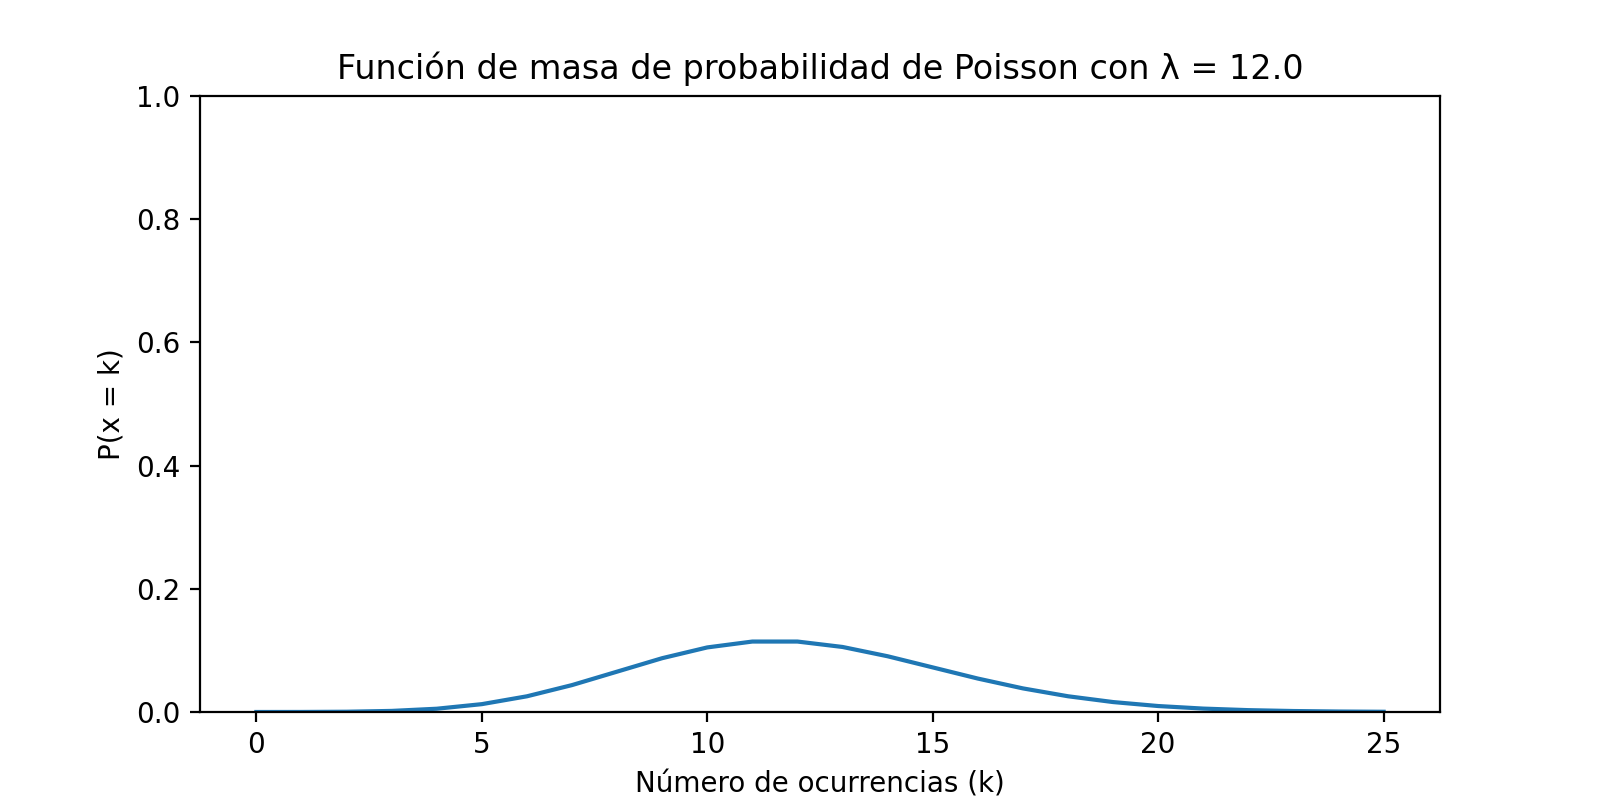

interactive(children=(FloatSlider(value=12.0, description='λ', max=25.0, step=0.5), Output()), _dom_classes=('…

In [2]:
k = np.arange(0,26,1)
fig, ax = plt.subplots(figsize=(8,4))
@widgets.interact(λ=(0, 25, 0.5))
def poissonMass(λ):
    y = poisson.pmf(k,λ)
    ax.cla()
    ax.set_title("Función de masa de probabilidad de Poisson con λ = " + str(λ))
    ax.set_ylim([0, 1])
    ax.set_ylabel("P(x = k)")
    ax.set_xlabel("Número de ocurrencias (k)")
    ax.plot(k,y)

Podemos ver que la distribución se asemeja a una distribución normal, cuya media parece ser igual al parámetro λ. También podemos observar que a medida que λ aumenta, también lo hace la varianza.
    
**2. Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida**
$$
\begin{align}
\log \mathcal{L}(\theta) &= \sum_{i=1}^N \log p(y_i | x_i) \nonumber \\
\nonumber \\ 
&= \sum_{i=1}^N \log\left(\frac{\lambda_i^{y_i}}{y_i!} e^{-\lambda_i}\right) \nonumber \\
\text{Usamos propiedad logarítmica:} \nonumber \\ 
\log(a \cdot b) = \log(a) + \log(b) \nonumber \\ 
\nonumber \\ 
&= \sum_{i=1}^N \left( \log\left(\frac{\lambda_i^{y_i}}{y_i!} \right) + \log\left(e^{-\lambda_i}\right) \right) \nonumber \\
&= \sum_{i=1}^N \left( \log\left(\frac{\lambda_i^{y_i}}{y_i!} \right) - \lambda_i \right)  \nonumber \\
\nonumber \\ 
\text{Usamos propiedad logarítmica:} \nonumber \\ 
\log\left(\frac{a}{b}\right) = \log(a) - \log(b) \nonumber \\ 
\nonumber \\ 
&= \sum_{i=1}^N \left( \log\left(\lambda_i^{y_i}\right) - \log(y_i!) - \lambda_i \right)  \nonumber \\
\nonumber \\ 
\text{Reemplazamos } \lambda_i \nonumber \\
\nonumber \\ 
&= \sum_{i=1}^N \left( \log \left(\left(e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)}\right)^{y_i}\right) - \log(y_i!) - e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)} \right) \nonumber \\
\nonumber \\ 
\text{Usamos propiedad exponencial:} \nonumber \\ 
(e^{a})^{b} = e^{a \cdot b} \nonumber \\ 
\nonumber \\ 
&= \sum_{i=1}^N \left( \log \left(e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)y_i}\right) - \log(y_i!) - e^{\left(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}\right)} \right) \nonumber \\
&= \sum_{i=1}^N \left( (\theta_0 + \sum_{j=1}^M \theta_j x_{ij}) y_i - \log(y_i!) - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\nonumber \\ 
\text{Por último, podemos eliminar } \log(y_i!) \text{ ya que no depende de }\theta \nonumber \\
\nonumber \\ 
&= \sum_{i=1}^N \left( (\theta_0 + \sum_{j=1}^M \theta_j x_{ij}) y_i - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\end{align}
$$

### Derivada
La derivada respecto a  $ \theta_j$ con $\text{j = 0}$ es:

$$
\begin{align}
\frac{d}{d\theta_0}\log \mathcal{L}(\theta) &= \sum_{i=1}^N\left( y_i - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\end{align}
$$

Y para $\text{j > 0}$ es:

$$
\begin{align}
\frac{d}{d\theta_j}\log \mathcal{L}(\theta) &= \sum_{i=1}^N\left( x_{ij} y_i - x_{ij}e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \right) \nonumber \\
\end{align}
$$

## Implementación (1.5pt)

**1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países)**


In [3]:
# Función de costo
def loglikelihood(theta,*args):
    x = args[0]
    y = args[1]
    
    p = theta[0] + np.sum(theta[1:]*x,axis=1)
    
    # Cambiamos signo para que se convierta en minimización
    return -np.sum(p*y - np.exp(p))


# Gradiente
def grad_loglikelihood(theta,*args):
    x = args[0]
    y = args[1]
    
    res = np.array([0,0,0,0]).astype('float128')
    
    # j = 0
    p = theta[0] + np.sum(theta[1:]*x,axis=1)
    res[0] = np.sum(y-np.exp(p))
    
    # j > 0
    res[1] = np.sum(x[:,0]*(y - np.exp(p)))
    res[2] = np.sum(x[:,1]*(y - np.exp(p)))
    res[3] = np.sum(x[:,2]*(y - np.exp(p)))
    
    return -res

**2. Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize`**


In [4]:
def findTheta(x,y,method='BFGS',thetaInit = np.array([0.0,0,0,0]),tol=1e-5):
    res = scipy.optimize.minimize(fun=loglikelihood,
                                    x0=thetaInit,
                                    method=method,
                                    jac=grad_loglikelihood,
                                    options={'maxiter':10e3,'maxfev':10e3},
                                    args=(x,y),
                                    tol=tol)
    return res

**3. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$**


In [5]:
# Suma de logaritmos de factoriales de un vector
def logFactorial(vec):
    suma = 0.0
    for y in vec:
        if y != 0:
            suma += np.sum(np.log(np.arange(1,y+1,1)))
    return suma

# Pseudo coeficiente de correlación de McFadden
def corrCoef(x,y,theta):
    
    # log(y!)
    yFact = logFactorial(y)
    
    # Mejor modelo solo theta
    theta0 = np.log(np.mean(y)+1e-100)
    
    logVer = -loglikelihood(theta,x,y)
    logVer0 = -loglikelihood(np.array([theta0,0,0,0]),x,y)
    return  (logVer0 - logVer)/(logVer0-yFact)

**4. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación**

In [6]:
# Poisson supone ocurrencias independienes por lo tanto utilizamos meustreo con reemplazo
def bootstrap(x,y,B,N,method):
    # B = número de muestras
    # N = tamaño de cada muestra
    
    # Almacena estadísticos de los datos ( muestra completa )
    resDatos = np.zeros(5,dtype='float128')
    
    # Calcula theta con todos los datos
    resDatos[:4] = findTheta(x,y,method,tol=1e-6).x

    # Y el coeficiente de correlación
    resDatos[4] = corrCoef(x,y,resDatos[:4])

    # Almacena coeficientesB
    resB = np.zeros((B,5),dtype='float128')

    for i in range(B):

        # Genera muestra aleatoria de N elementos
        indexs = np.random.choice(N, size=N, replace=True)    
        yB = y[indexs]
        xB = x[indexs,:]

        # Calcula coeficientes en cada muestra B
        success = False
        while success == False:
            thetaInit = np.array([0.0,0,0,0]) + 1.0 * np.random.randn(4)

            res = scipy.optimize.minimize(fun=loglikelihood,
                                        x0=thetaInit,
                                        method=method,
                                        jac=grad_loglikelihood,
                                        args=(xB,yB),
                                        tol=1e-5)
            success = res.success
                
        
        # Guardamos thetaB
        resB[i,:4] = res.x

        # Guardamos coefCorrB
        resB[i,4] = corrCoef(xB,yB,res.x)

    intervalos = np.zeros((5,2))
    for i in range(5):
        intervalos[i,:] = np.quantile(a = resB[:,i], q = [0.025, 0.975])
    
    return resB,resDatos,intervalos

## Resultados (3pt)

1. Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos

In [7]:
tol = 1e-9
methods = ['CG','BFGS','Nelder-mead','Powell']
results = pd.DataFrame(columns=['Método','Iters','Log Verosimilitud','Coef Correlación','θ0','θ1','θ2','θ3'])

for i in range(len(methods)):
    %timeit -r 5 -n 5 findTheta(x,y,methods[i],tol=tol)
    res = findTheta(x,y,methods[i],tol=tol)
    results.loc[i] = [methods[i],res.nit,res.fun,corrCoef(x,y,res.x),res.x[0],res.x[1],res.x[2],res.x[3]]
results

314 ms ± 1.24 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
5.31 ms ± 33.8 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)
544 ms ± 4.01 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)
65 ms ± 225 µs per loop (mean ± std. dev. of 5 runs, 5 loops each)


,Método,Iters,Log Verosimilitud,Coef Correlación,θ0,θ1,θ2,θ3
0,CG,842,-3459.091942,0.857371,-29.049549,1.083856,1.171363,0.005968
1,BFGS,17,-3459.091942,0.857371,-29.049541,1.083856,1.171362,0.005968
2,Nelder-mead,5077,-3459.091942,0.857371,-29.049541,1.083856,1.171362,0.005968
3,Powell,15,-3459.091942,0.857371,-29.049545,1.083855,1.171363,0.005968


Podemos observar que todos los métodos convergen al mismo valor (con ínfimas diferencias en los valores de theta). La principal diferencia radica en el número de iteraciones necesarias para converger y el tiempo empleado.
El algoritmo que registra un mejor rendimiento es **BFGS** con un tiempo promedio de 6.24 milisegundos y 17 iteraciones, el algoritmo **Powell** requiere menos iteraciones pero tarda casi un órden de magnitud más en converger, probablemente porque no hace uso de la función gradiente implementada previamente. Dicho eso, optamos por el método **BFGS**.

2. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?

In [8]:
resB,resDatos,intervalos = bootstrap(x,y,B=10000,N=len(y),method='BFGS')

<IPython.core.display.Javascript object>


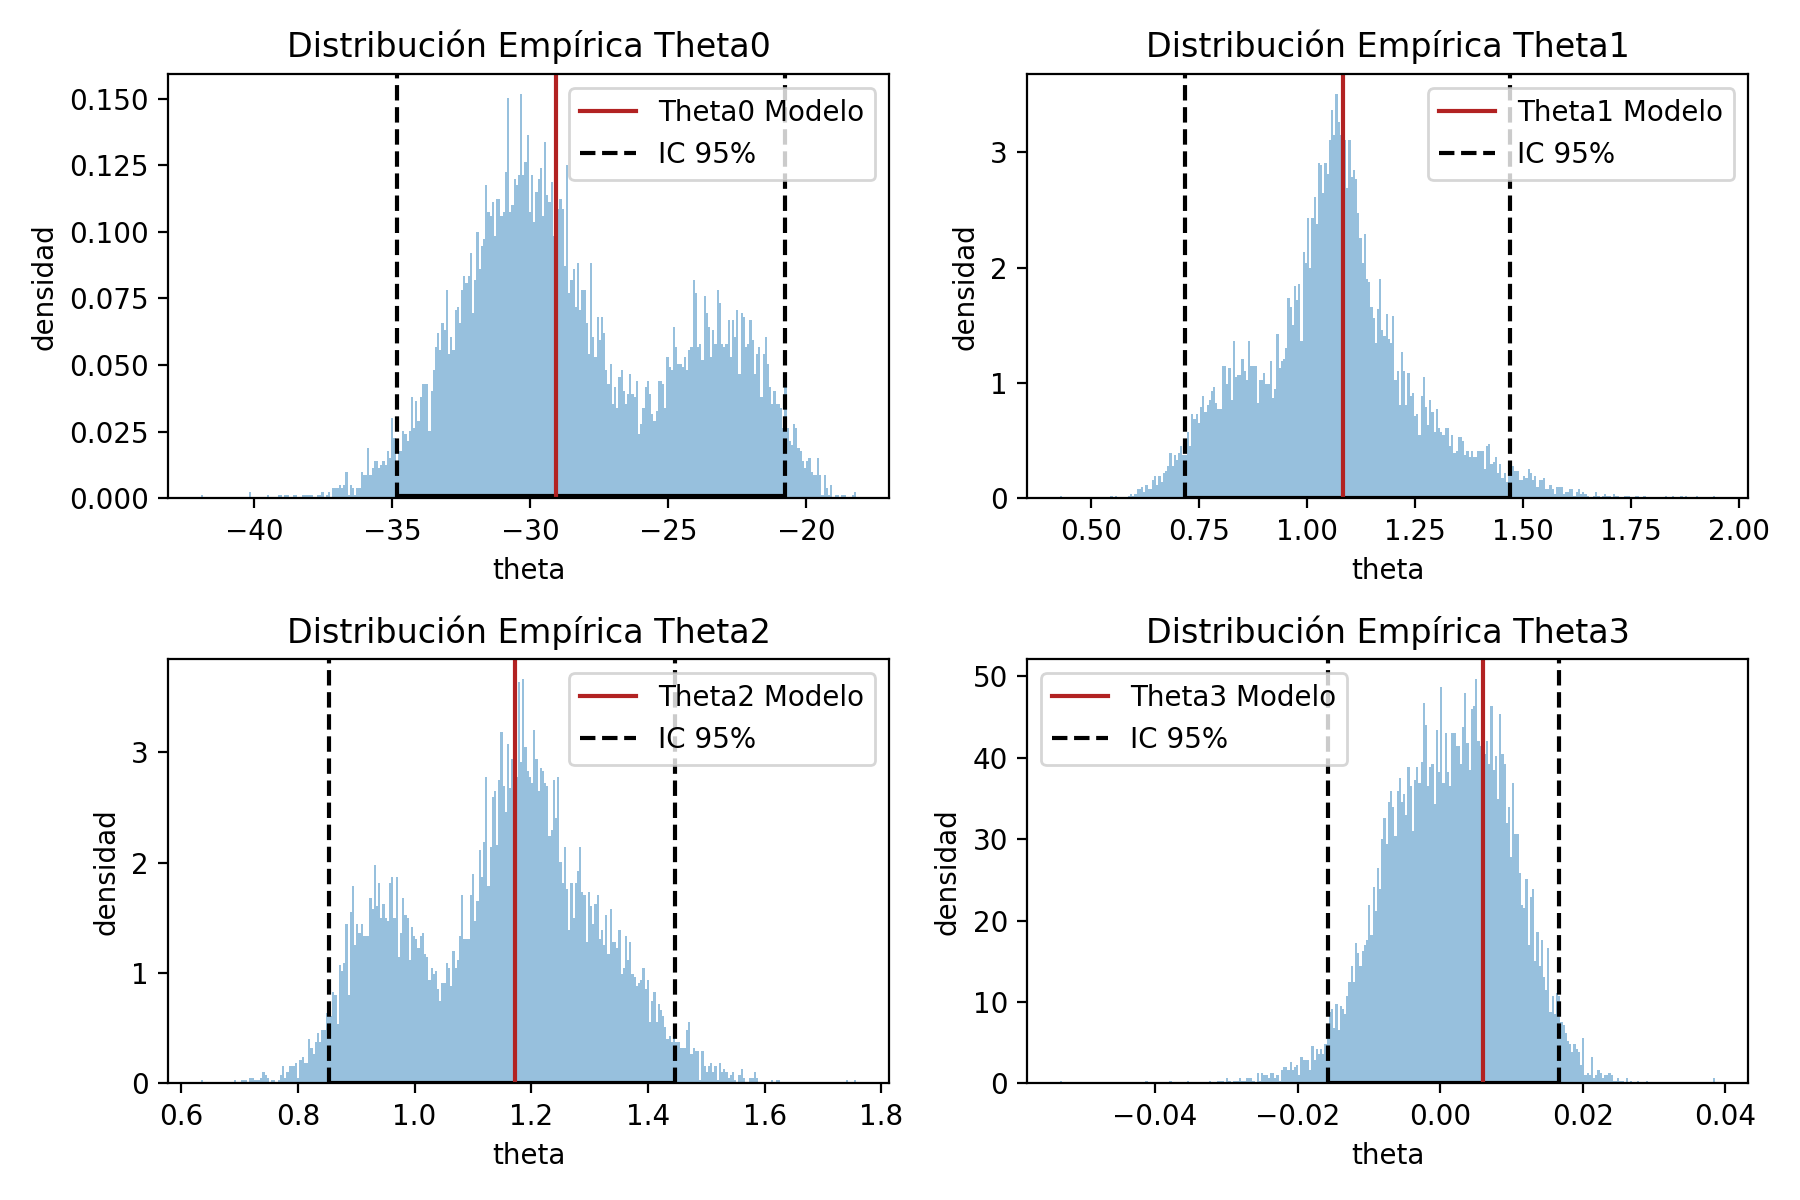

In [9]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(9,6),tight_layout=True)
g = 0
for i in range(2):
    for j in range(2):   
        ax[i,j].hist(resB[:,g], bins=300, density=True, color='#3182bd', alpha=0.5)
        ax[i,j].axvline(x=resDatos[g], color='firebrick', label='Theta'+str(g)+' Modelo')
        ax[i,j].axvline(x=intervalos[g][0], color='black', linestyle='--', label='IC 95%')
        ax[i,j].axvline(x=intervalos[g][1], color='black', linestyle='--')
        ax[i,j].hlines(y=0.001, xmin=intervalos[g][0], xmax=intervalos[g][1], color='black')
        ax[i,j].set_title('Distribución Empírica Theta'+str(g))
        ax[i,j].set_xlabel('theta')
        ax[i,j].set_ylabel('densidad')
        ax[i,j].legend();
        g+=1

Podemos ver que ambas modas del coeficiente theta0 (media flotante) se alejan bastante de 0, a diferencia del resto, sobre todo theta3, que corresponde al peso del parámetro GATT, cuya moda está prácticamente centrada en 0. Por lo tanto podemos inferir que la variable GATT no aporta demasiada información al modelo, o dicho de otra forma, no posee una correlación fuerte con la cantidad de billonarios de un país, a diferencia del PIB y la cantidad de población ( con pesos theta1 y theta2 respectativamente) que si poseen una clara correlación positiva.

<IPython.core.display.Javascript object>


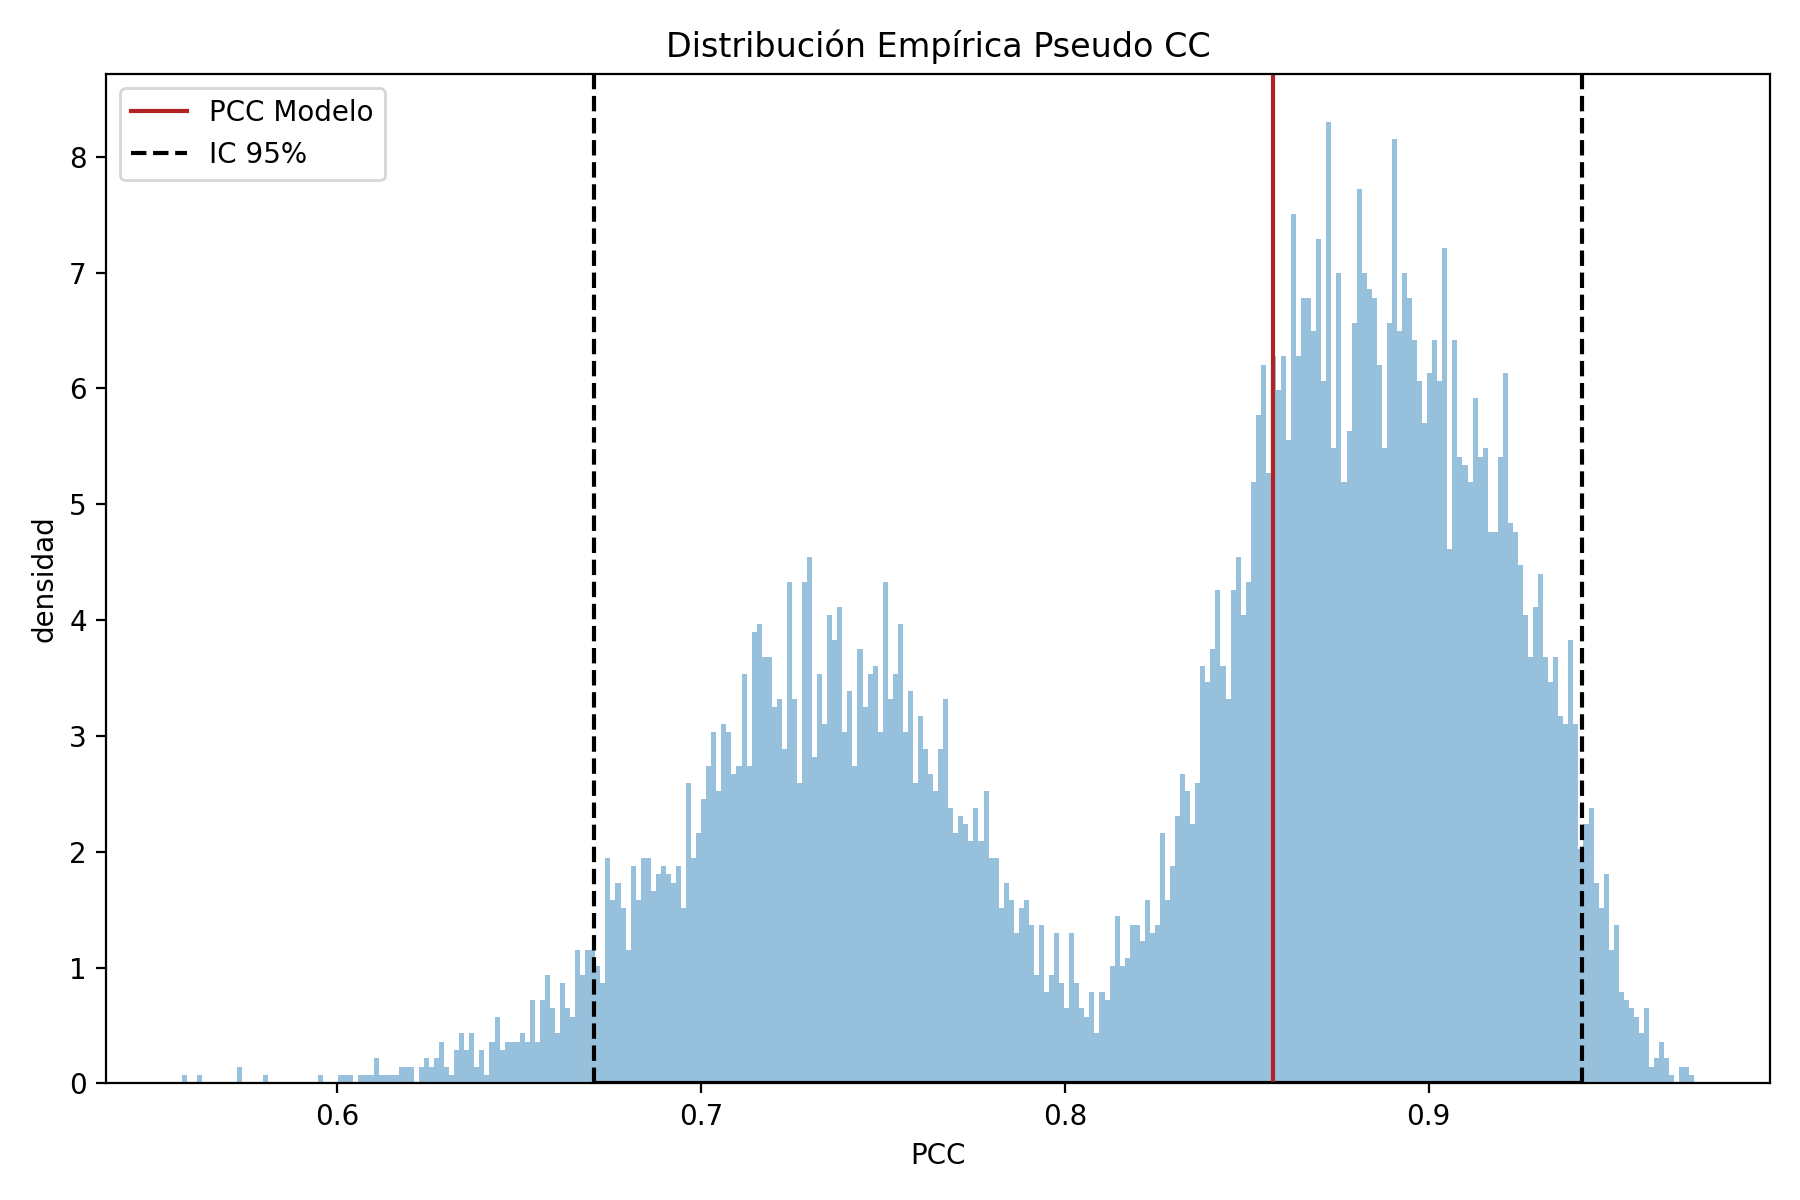

In [10]:
# PCC
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,6),tight_layout=True)
ax.hist(resB[:,4], bins=300, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=resDatos[4], color='firebrick', label='PCC Modelo')
ax.axvline(x=intervalos[4][0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=intervalos[4][1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=intervalos[4][0], xmax=intervalos[4][1], color='black')
ax.set_title('Distribución Empírica Pseudo CC')
ax.set_xlabel('PCC')
ax.set_ylabel('densidad')
ax.legend();

El intervalo de confianza al 95% de $R^2$ es: $[0.67147728, 0.94130836]$

Al existir dos modas, creemos que hay dos grupos de países a los cuales el modelo podría ajustarse correctamente por separado. Probablemente existen variables adicionales que hubiesen explicado esta separación en un modelo con más dimensiones, pero esas variables no se tomaron en cuenta en este trabajo. Dado que el $R^2$ obtenido con todos los datos se aproxima más a la segunda moda, podemos inferir que nuestro modelo será bueno para predecir países similares a ese grupo pero el grado de incerteza aumentará en otro caso. 

3. Prediga la cantidad de billonarios de cada país usando su modelo. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?

Dado que el modelo genera una distribución de Poisson específica para cada input x, y sabemos que su media es equivalente a su parámetro $\lambda$, podemos utilizar: 

$$
\lambda = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{j} \right)
$$

Para predecir la cantidad de billonarios, pero con el resultado truncado para obtener valores discretos.

$$
y = floor \left( \lambda \right)
$$

In [37]:
def model(x,theta):
    return np.floor(np.exp(theta[0]+np.sum(x*theta[1:],axis=1)))

In [38]:
yReal = df.iloc[:,0:4]
yPred = model(x,resDatos[:4])

In [39]:
# Error absoluto
yErr = yReal.copy()
yErr.columns = ['pais','real','pred','err']
yErr.iloc[:,2] = yPred
yErr.iloc[:,3] = np.abs(yErr.iloc[:,1] - yPred[:])
yErr = yErr.sort_values(by=['err'],ascending=False)

<IPython.core.display.Javascript object>


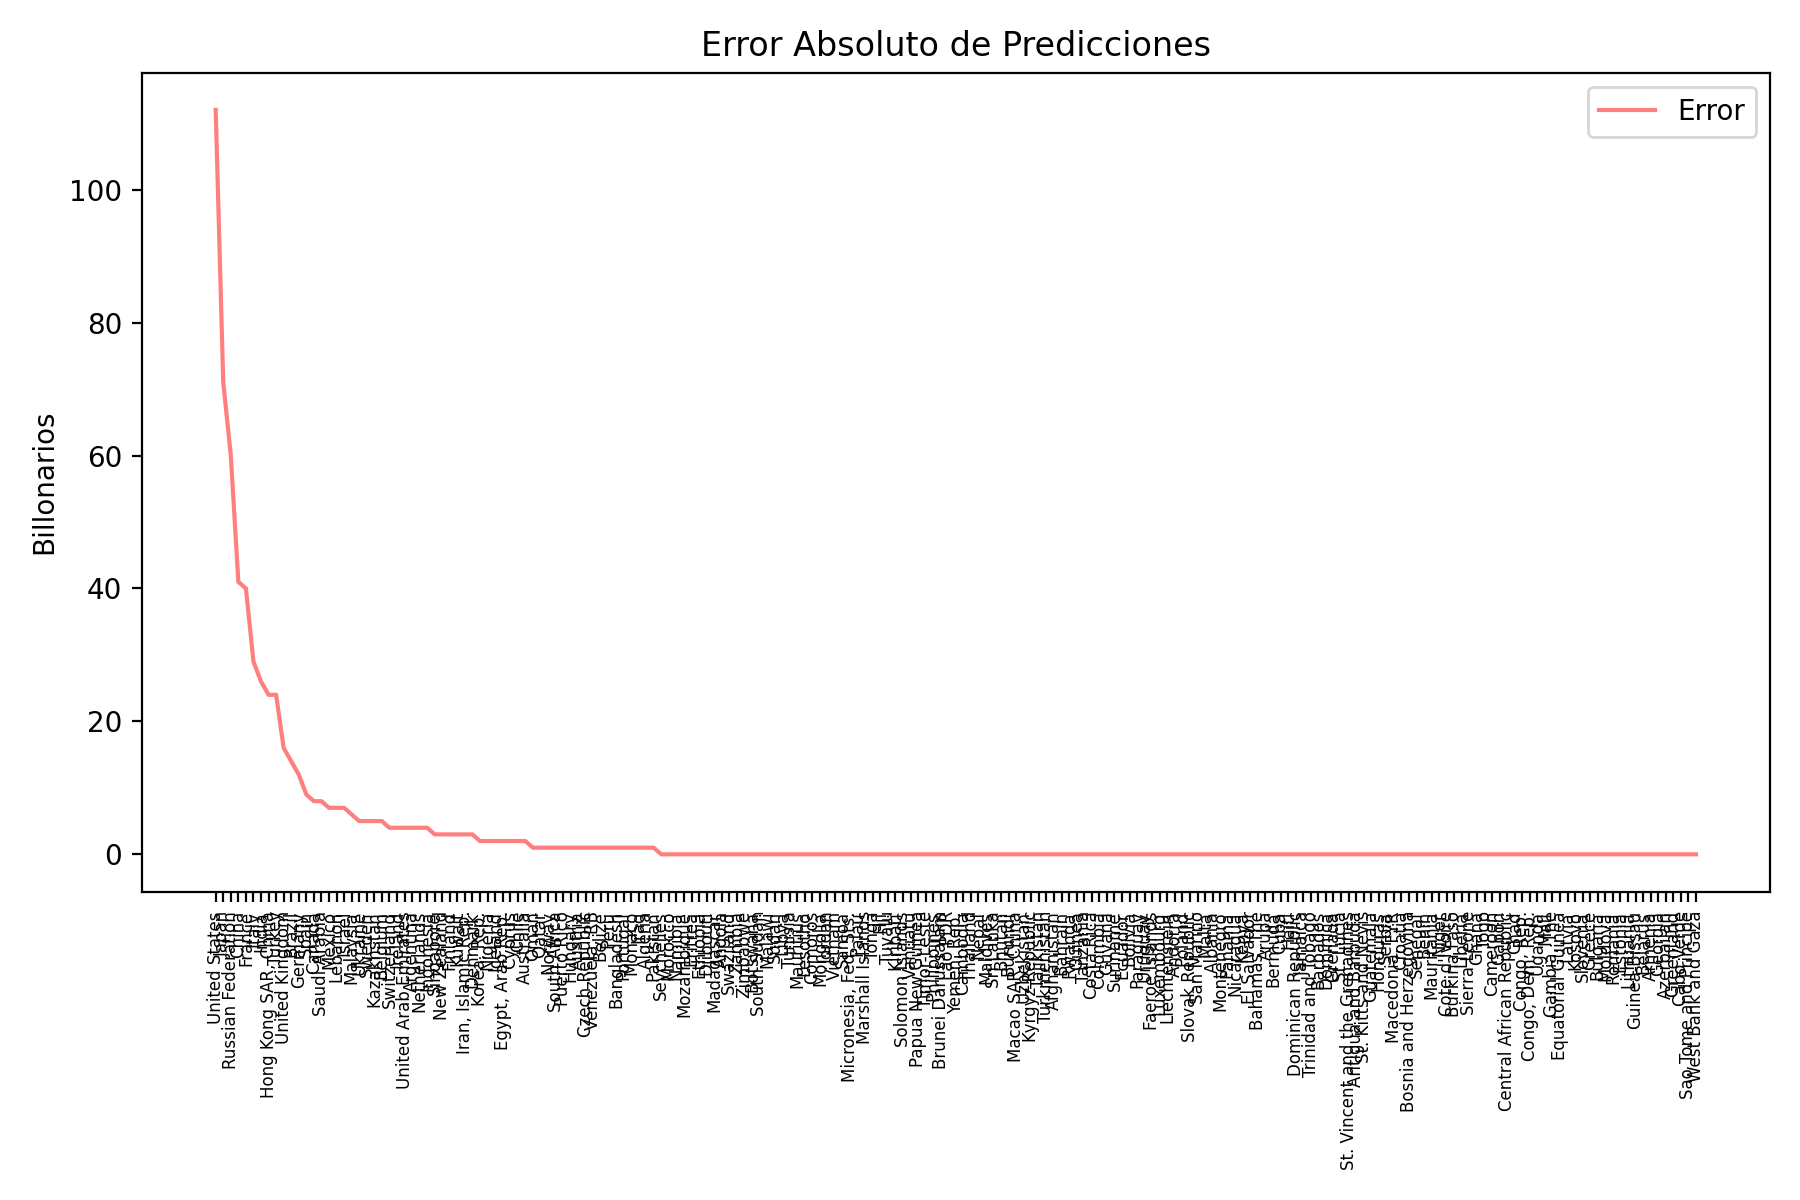

In [40]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,6),tight_layout=True)
ax.set_title('Error Absoluto de Predicciones')
ax.set_ylabel('Billonarios')
plt.plot(yErr.iloc[:,0], yErr.iloc[:,3], c='red',alpha=0.5,label='Error')
plt.xticks(rotation=90,fontsize=6)
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


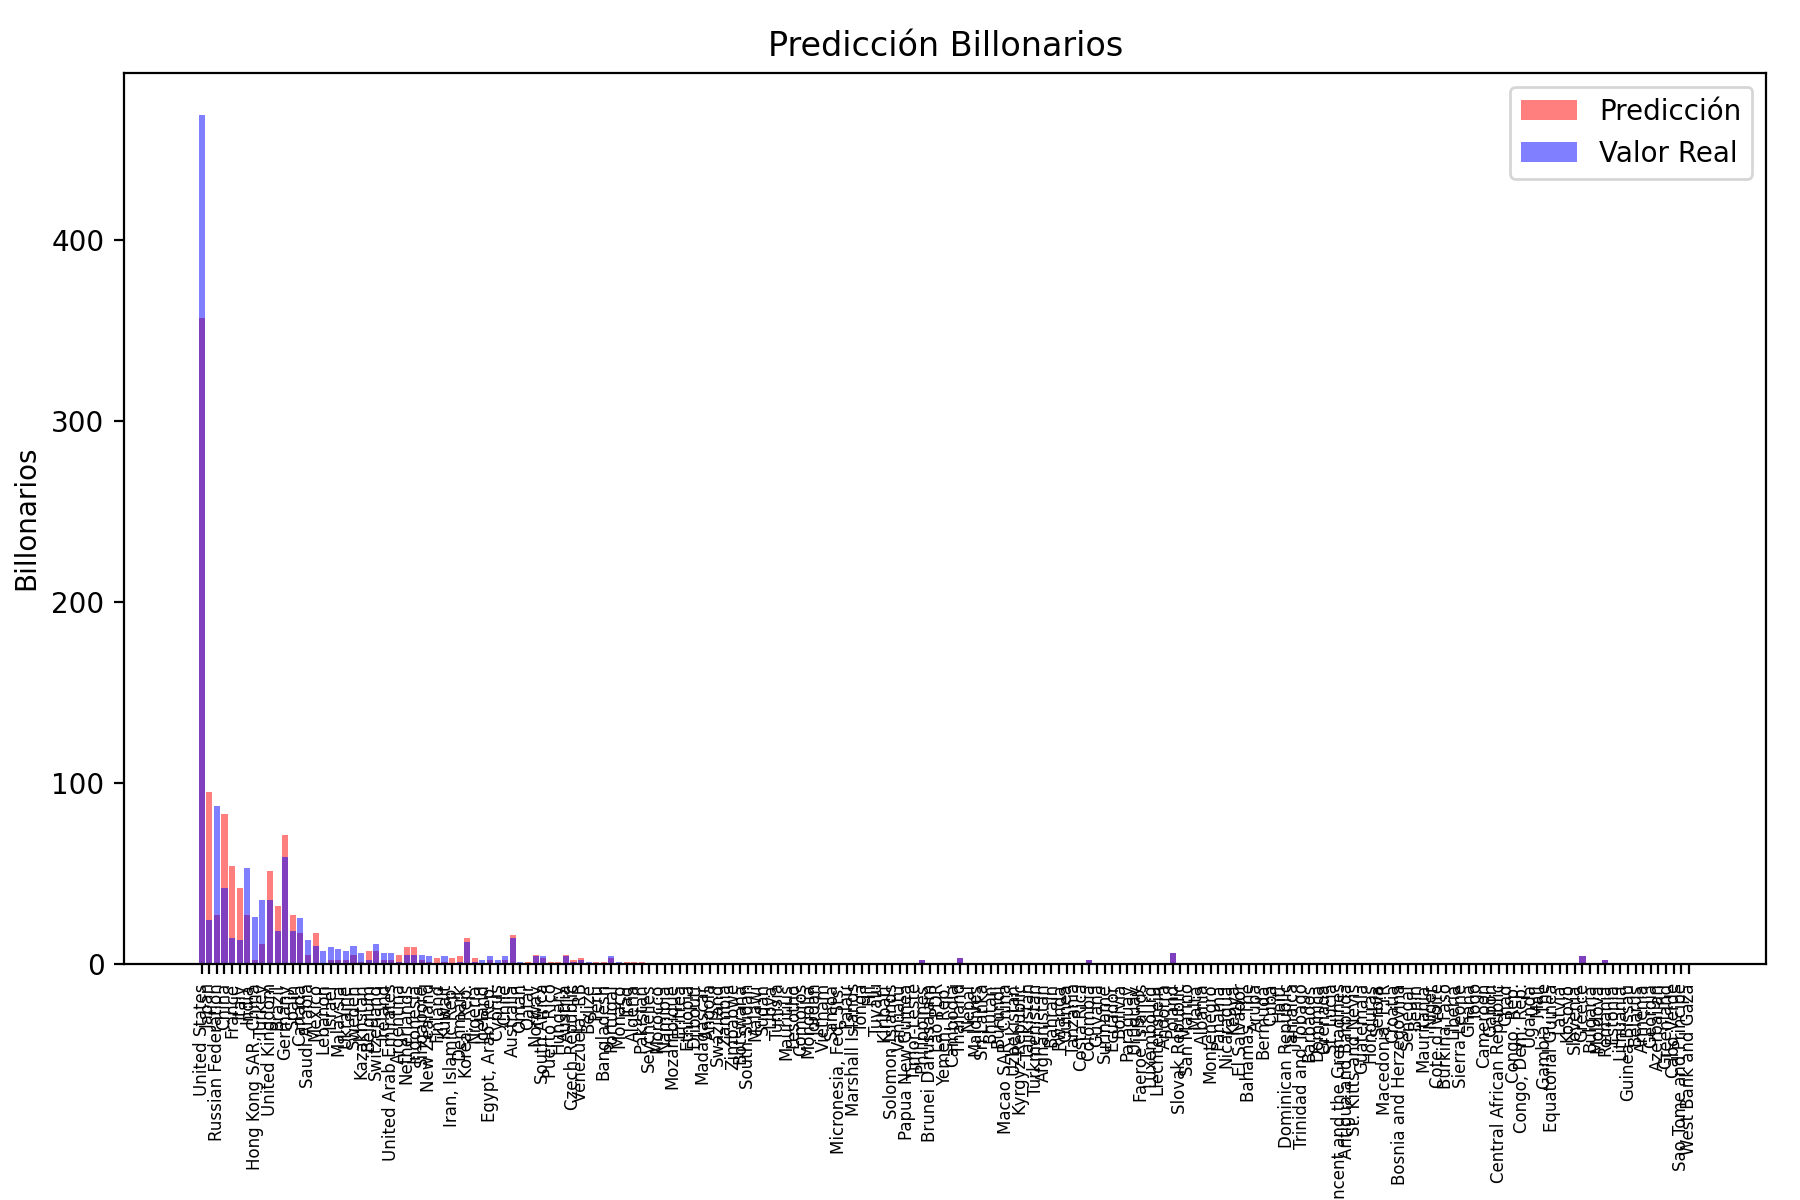

In [43]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,6),tight_layout=True)
ax.set_title('Predicción Billonarios')
ax.set_ylabel('Billonarios')
plt.bar(yErr.iloc[:,0], yErr.iloc[:,2],color='red',alpha=0.5,label='Predicción')
plt.bar(yErr.iloc[:,0], yErr.iloc[:,1],color='blue',alpha=0.5,label='Valor Real')
plt.xticks(rotation=90,fontsize=6)
#plt.yscale('log')
ax.legend()
plt.show()

Para la mayoría de países el error es cero, por lo que el modelo funciona relativamente bien, pero a la izquierda vemos algunos países donde el error es muy alto en comparación.

Los cinco países con mayor error absoluto son:

In [16]:
yErr.head(5)

,pais,real,pred,err
0,United States,469,357.0,112.0
163,Japan,24,95.0,71.0
72,Russian Federation,87,27.0,60.0
159,China,42,83.0,41.0
43,France,14,54.0,40.0


Rusia tiene 87 más billonarios que lo predicho. Se debe tener en cuenta que estos países tienen grandes diferencias en los tamaños de sus poblaciones.

In [26]:
# Cociente entre valor real y valor predicho
yErr['real/pred'] = yErr[['real']].div(yErr['pred'].values,axis=0)
yErr.sort_values(by='real/pred', ascending=False).head(15)

,pais,real,pred,err,real/pred
68,Cyprus,2,0.0,2.0,inf
85,Iceland,2,0.0,2.0,inf
44,Monaco,1,0.0,1.0,inf
18,Belize,1,0.0,1.0,inf
143,Lebanon,7,0.0,7.0,inf
152,Oman,1,0.0,1.0,inf
194,"Hong Kong SAR, China",26,2.0,24.0,13.000000
158,Kazakhstan,6,1.0,5.0,6.000000
145,Israel,9,2.0,7.0,4.500000
148,Kuwait,4,1.0,3.0,4.000000


Es decir, Rusia tiene 3.2 veces la cantidad de billonarios predicha por el modelo. Por lo tanto, Rusia se ubica en el lado superior de la tabla tanto en terminos de error absoluto como en error relativo.

In [27]:
# Países que tienen más billonarios de lo esperado
yErr.loc[yErr['real'] > yErr['pred']]

,pais,real,pred,err,real/pred
0,United States,469,357.0,112.0,1.313725
72,Russian Federation,87,27.0,60.0,3.222222
164,India,53,27.0,26.0,1.962963
194,"Hong Kong SAR, China",26,2.0,24.0,13.000000
140,Turkey,35,11.0,24.0,3.181818
1,Canada,25,17.0,8.0,1.470588
146,Saudi Arabia,13,5.0,8.0,2.600000
143,Lebanon,7,0.0,7.0,inf
145,Israel,9,2.0,7.0,4.500000
175,Malaysia,8,2.0,6.0,4.000000


In [28]:
# Países que tienen menos billonarios de lo esperado
yErr.loc[yErr['pred'] > yErr['real']]

,pais,real,pred,err,real/pred
163,Japan,24,95.0,71.0,0.252632
159,China,42,83.0,41.0,0.506024
43,France,14,54.0,40.0,0.259259
56,Italy,13,42.0,29.0,0.309524
38,United Kingdom,35,51.0,16.0,0.686275
31,Brazil,18,32.0,14.0,0.562500
50,Germany,59,71.0,12.0,0.830986
47,Spain,18,27.0,9.0,0.666667
17,Mexico,10,17.0,7.0,0.588235
41,Belgium,2,7.0,5.0,0.285714


## Conclusiones (0.5pt)

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 

Efectivamente, Rusia tiene una cantidad de billonarios bastante más alta que lo esperable según los datos. Sin embargo, Rusia no es el único país donde esto ocurre. Por ejemplo, en Estados Unidos el error fue mayor: hay más de 100 billonarios más que lo predicho por nuestro modelo.

En términos relativos, Rusia tampoco es el país donde este error fue mayor: Hong Kong tiene 13 veces la cantidad de billonarios esperable según sus datos económicos, mientras que en Rusia hay 3.2 veces la cantidad de billonarios esperada.

En cuanto a desafíos y dudas, discutimos si era mejor mostrar solo el error absoluto de la predicción o también el error relativo a la población (o su logarítmo) de cada país. El argumento a favor de mostrar ambos es que, como mencionamos en los resultados, a mayor poblacion el error absoluto será naturalmente mayor, independiente de los comportamientos subyacentes que estamos tratando de modelar.